## Final Project Submission

Please fill out:
* Student name: Moses Lin
* Student pace: full time
* Scheduled project review date/time: 7/31/2020
* Instructor name: Sean Abu Wilson
* Blog post URL:

# Source:

Data was downloaded from Kaggle, and contains a dataset of Steam Games gathered from the Steam Store and SteamSpy API around May 2019.

https://www.kaggle.com/nikdavis/steam-store-games

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('seaborn')
sns.set(style="white")
import itertools
import re
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from math import exp

In [2]:
df = pd.read_csv('steam.csv')
df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


# Cleaning Data

As usual, first thing to do is to check for null values. It is ideal to fill in values for observations if possible instead of outright removing them, as we would be losing a lot of data.

In [3]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

df.isna().sum()
#Checking how many missing numbers there are
#Makes sense, since this dataset said it was "clean"

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

In [4]:
#about 1.9% of all games in this set are not in English, will drop non-english games.
print(511/(26564+511))
df['english'].value_counts()

0.01887349953831948


1    26564
0      511
Name: english, dtype: int64

In [5]:
df['required_age'].value_counts()
#seems most games do not have a rating listed, will drop this column

0     26479
18      308
16      192
12       73
7        12
3        11
Name: required_age, dtype: int64

In [6]:
#Dropping columns that don't seem particularly useful.
df.drop(columns=['appid', 'steamspy_tags', 'english', 'required_age', 'owners'], inplace=True)
df.head()

,name,release_date,developer,publisher,platforms,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
0,Counter-Strike,2000-11-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,124534,3339,17612,317,7.19
1,Team Fortress Classic,1999-04-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,3318,633,277,62,3.99
2,Day of Defeat,2003-05-01,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,0,3416,398,187,34,3.99
3,Deathmatch Classic,2001-06-01,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,1273,267,258,184,3.99
4,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,0,5250,288,624,415,3.99


In [7]:
from datetime import datetime
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
    return abs((d2 - d1).days)

df['release_date'] = df['release_date'].astype('datetime64[ns]')
df['release_year'] = df['release_date'].apply(lambda x: x.year)

df['days_from_launch'] = df['release_date'].apply(lambda row: days_between(f'{row}', '2019-05-28 0:0:0'))
df = df.drop(columns='release_date')

In [8]:
df['price'].sort_values(ascending=False).head(30)
df['price'] = df.price[df['price'] < 70.00]

# Target Variable

Because number of positive reviews out of negative reviews is a little vague, and not really representative of scoring if there are very few reviews. I will be using the formula from https://steamdb.info/blog/steamdb-rating/.

totalreview = positiverating + negativerating

reviewscore = positiverating / totalreview

rating = reviewscore - (reviewscore - 0.5) * (2**(-log10(totalreview + 1)))

In [9]:
import numpy as np
df['totalreview'] = df['positive_ratings'] + df['negative_ratings']
df['reviewscore'] = df['positive_ratings'] / df['totalreview']
df['rating'] = df['reviewscore'] - (df['reviewscore'] - 0.5) * (2 ** (-np.log10(df['totalreview'] + 1)))
df.head()

,name,developer,publisher,platforms,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,days_from_launch,totalreview,reviewscore,rating
0,Counter-Strike,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,124534,3339,17612,317,7.19,2000,6782,127873,0.973888,0.960136
1,Team Fortress Classic,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,3318,633,277,62,3.99,1999,7362,3951,0.839787,0.811703
2,Day of Defeat,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,0,3416,398,187,34,3.99,2003,5871,3814,0.895648,0.862598
3,Deathmatch Classic,Valve,Valve,windows;mac;linux,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,1273,267,258,184,3.99,2001,6570,1540,0.826623,0.790779
4,Half-Life: Opposing Force,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,0,5250,288,624,415,3.99,1999,7148,5538,0.947996,0.914546


In [10]:
top10 = df.nlargest(10, ['rating'])
worst10 = df.nsmallest(10, ['rating'])

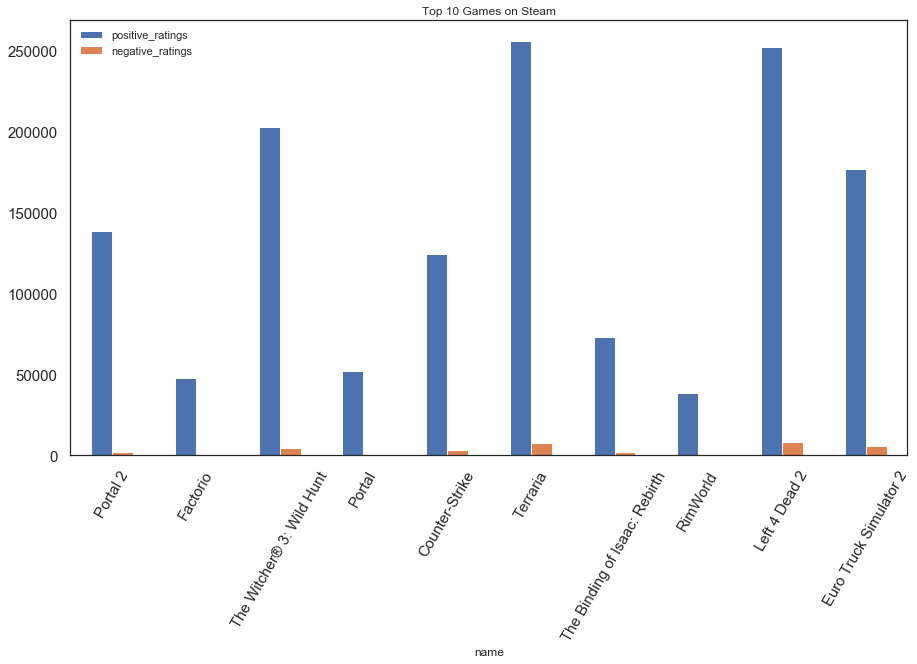

In [11]:
top10.plot(x='name', y=['positive_ratings', 'negative_ratings'], kind='bar', figsize=(15,8),title='Top 10 Games on Steam', fontsize=15, rot=60)

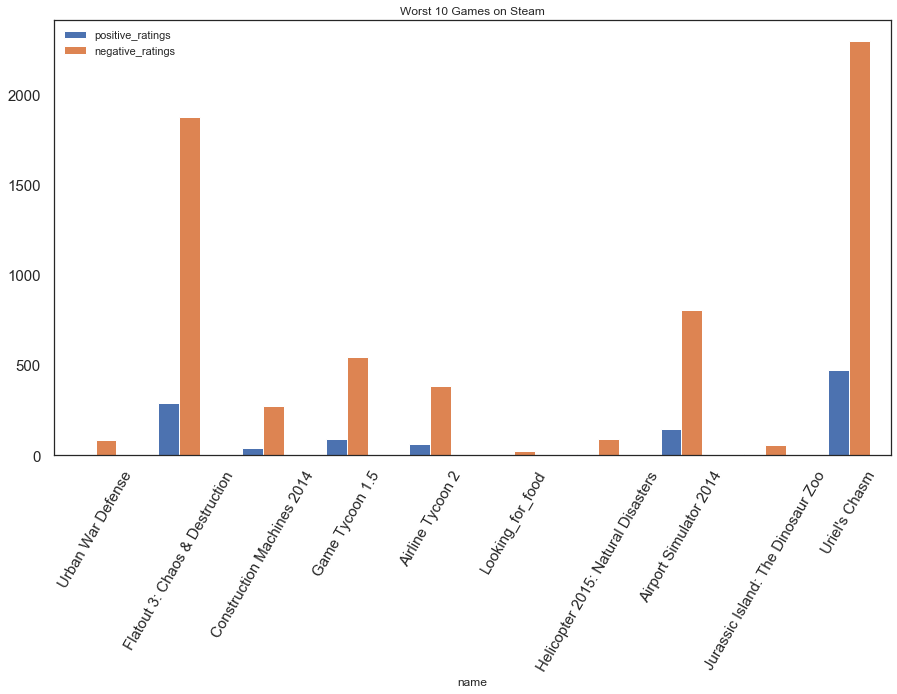

In [12]:
worst10.plot(x='name', y=['positive_ratings', 'negative_ratings'], kind='bar', figsize=(15,8),title='Worst 10 Games on Steam', fontsize=15, rot=60)

# Exploratory Data Analysis

In [13]:
df2005up = df[df['release_year'].between(2005, 2018)]
df2005up

,name,developer,publisher,platforms,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,days_from_launch,totalreview,reviewscore,rating
12,Day of Defeat: Source,Valve,Valve,windows;mac;linux,Multi-player;Cross-Platform Multiplayer;Steam ...,Action,54,10489,1210,1356,134,7.19,2010,3242,11699,0.896572,0.872931
14,Half-Life 2: Lost Coast,Valve,Valve,windows;mac;linux,Single-player;Commentary available,Action,0,5783,1020,46,29,0.00,2005,4961,6803,0.850066,0.825498
15,Half-Life Deathmatch: Source,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled,Action,0,1362,473,102,81,0.00,2006,4775,1835,0.742234,0.717016
16,Half-Life 2: Episode One,Valve,Valve,windows;mac;linux,Single-player;Steam Achievements;Captions avai...,Action,13,7908,517,281,184,5.79,2006,4744,8425,0.938635,0.909770
17,Portal,Valve,Valve,windows;mac;linux,Single-player;Steam Achievements;Captions avai...,Action,15,51801,1080,288,137,7.19,2007,4248,52881,0.979577,0.961422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26046,BLASTER LiLO,Fabio Cardini,Fabio Cardini,windows,Single-player;Online Multi-Player;Steam Achiev...,Action,14,1,0,0,0,1.99,2018,151,1,1.000000,0.594164
26047,Mobile Wars X,NAPE GAMES,NAPE GAMES,windows,Single-player,Action;Casual;Free to Play;Indie,0,16,6,0,0,0.00,2018,151,22,0.727273,0.638837
26074,Tower Behind the Moon,Choice of Games,Choice of Games,windows;mac;linux,Single-player;Steam Achievements;Steam Cloud,Adventure;Indie;RPG,35,6,4,0,0,5.19,2018,159,10,0.600000,0.551414
26082,aMAZE Valentine,Blender Games,Blender Games,windows,Single-player;Steam Achievements,Casual;Indie,100,13,2,0,0,0.79,2018,151,15,0.866667,0.707521


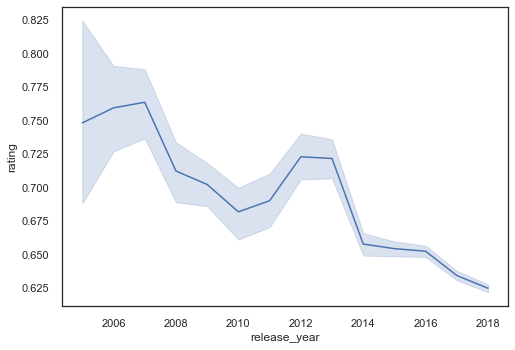

In [14]:
ax = sns.lineplot(x="release_year", y="rating", data=df2005up)

In [15]:
print(df['achievements'].value_counts())

print(df.achievements[df.achievements == 0].count())
print(df.achievements[df.achievements > 0].count())
# Will separate into dummy column of whether there are achievements or not

0       11864
10        679
12        618
20        574
15        490
        ...  
184         1
168         1
1487        1
319         1
4094        1
Name: achievements, Length: 410, dtype: int64
11864
15211


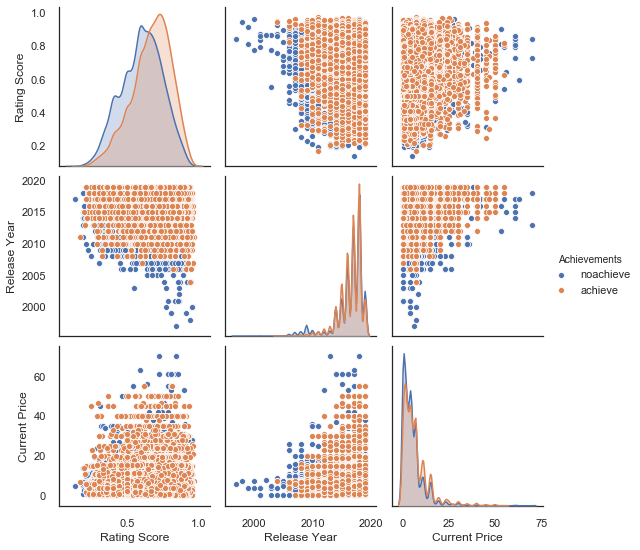

In [16]:
df['containachieve'] = 'noachieve'
df.loc[df['achievements'] > 0, 'containachieve'] = 'achieve'

achievedf = pd.DataFrame(zip(df['rating'],
                          df['release_year'],
                          df['price'],
                          df['containachieve']
                         ),
                      columns=['Rating Score', 'Release Year', 'Current Price', 'Achievements'])

sns.pairplot(achievedf, hue='Achievements')
plt.show()

In [17]:
print(df['price'].value_counts())

print(df.price[df.price == 0.00].count())
print(df.price[df.price > 0.00].count())

3.99     3211
0.79     2892
0.00     2560
6.99     2050
7.19     1304
         ... 
15.40       1
7.74        1
19.90       1
6.35        1
6.28        1
Name: price, Length: 271, dtype: int64
2560
24495


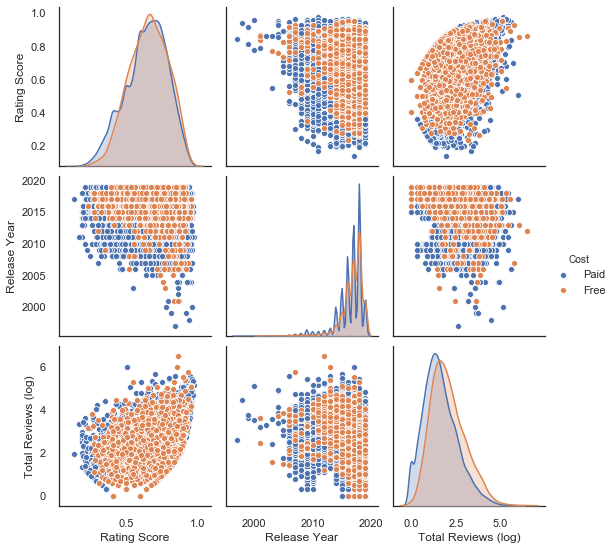

In [18]:
df['Cost'] = 'Free'
df.loc[df['price'] > 0, 'Cost'] = 'Paid'

achievedf = pd.DataFrame(zip(df['rating'],
                          df['release_year'],
                          np.log10(df['totalreview']),
                          df['Cost']
                         ),
                      columns=['Rating Score', 'Release Year', 'Total Reviews (log)', 'Cost'])

sns.pairplot(achievedf, hue='Cost')
plt.show()

# Feature Engineering

In [19]:
def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

#Get unique values from a Pandas series containing semi-colon delimited strings.

In [20]:
platformcols = get_unique(df['platforms'])
platformcols

for col in platformcols:
    df[col] = df['platforms'].apply(lambda x: 1 if col in x.split(';') else 0)

df = df.drop(columns='platforms')
df

,name,developer,publisher,categories,genres,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,days_from_launch,totalreview,reviewscore,rating,containachieve,Cost,mac,linux,windows
0,Counter-Strike,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,124534,3339,17612,317,7.19,2000,6782,127873,0.973888,0.960136,noachieve,Paid,1,1,1
1,Team Fortress Classic,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,3318,633,277,62,3.99,1999,7362,3951,0.839787,0.811703,noachieve,Paid,1,1,1
2,Day of Defeat,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,0,3416,398,187,34,3.99,2003,5871,3814,0.895648,0.862598,noachieve,Paid,1,1,1
3,Deathmatch Classic,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,0,1273,267,258,184,3.99,2001,6570,1540,0.826623,0.790779,noachieve,Paid,1,1,1
4,Half-Life: Opposing Force,Gearbox Software,Valve,Single-player;Multi-player;Valve Anti-Cheat en...,Action,0,5250,288,624,415,3.99,1999,7148,5538,0.947996,0.914546,noachieve,Paid,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,SHEN JIAWEI,SHEN JIAWEI,Single-player;Steam Achievements,Adventure;Casual;Indie,7,3,0,0,0,2.09,2019,34,3,1.000000,0.670594,achieve,Paid,0,0,1
27071,Cyber Gun,Semyon Maximov,BekkerDev Studio,Single-player,Action;Adventure;Indie,0,8,1,0,0,1.69,2019,35,9,0.888889,0.694444,noachieve,Paid,0,0,1
27072,Super Star Blast,EntwicklerX,EntwicklerX,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,24,0,1,0,0,3.99,2019,34,1,0.000000,0.405836,achieve,Paid,0,0,1
27073,New Yankee 7: Deer Hunters,Yustas Game Studio,Alawar Entertainment,Single-player;Steam Cloud,Adventure;Casual;Indie,0,2,0,0,0,5.19,2019,41,2,1.000000,0.640795,noachieve,Paid,1,0,1


In [21]:
platcolval = df[list(platformcols)]
platcolval.head(3)

,mac,linux,windows
0,1,1,1
1,1,1,1
2,1,1,1


In [22]:
genrecols = get_unique(df['genres'])
genrecols

for col in genrecols:
    df[col] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)

df = df.drop(columns='genres')
df

,name,developer,publisher,categories,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,days_from_launch,totalreview,reviewscore,rating,containachieve,Cost,mac,linux,windows,Audio Production,Game Development,Documentary,Indie,Accounting,Simulation,Nudity,Free to Play,Violent,Utilities,Animation & Modeling,Massively Multiplayer,Design & Illustration,Strategy,Sports,Gore,Web Publishing,Education,Software Training,Racing,RPG,Tutorial,Sexual Content,Video Production,Early Access,Casual,Photo Editing,Action,Adventure
0,Counter-Strike,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,0,124534,3339,17612,317,7.19,2000,6782,127873,0.973888,0.960136,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Team Fortress Classic,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,0,3318,633,277,62,3.99,1999,7362,3951,0.839787,0.811703,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Day of Defeat,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,0,3416,398,187,34,3.99,2003,5871,3814,0.895648,0.862598,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Deathmatch Classic,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,0,1273,267,258,184,3.99,2001,6570,1540,0.826623,0.790779,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Half-Life: Opposing Force,Gearbox Software,Valve,Single-player;Multi-player;Valve Anti-Cheat en...,0,5250,288,624,415,3.99,1999,7148,5538,0.947996,0.914546,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,SHEN JIAWEI,SHEN JIAWEI,Single-player;Steam Achievements,7,3,0,0,0,2.09,2019,34,3,1.000000,0.670594,achieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
27071,Cyber Gun,Semyon Maximov,BekkerDev Studio,Single-player,0,8,1,0,0,1.69,2019,35,9,0.888889,0.694444,noachieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
27072,Super Star Blast,EntwicklerX,EntwicklerX,Single-player;Multi-player;Co-op;Shared/Split ...,24,0,1,0,0,3.99,2019,34,1,0.000000,0.405836,achieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
27073,New Yankee 7: Deer Hunters,Yustas Game Studio,Alawar Entertainment,Single-player;Steam Cloud,0,2,0,0,0,5.19,2019,41,2,1.000000,0.640795,noachieve,Paid,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [23]:
gencolval = df[list(genrecols)]
gencolval

,Audio Production,Game Development,Documentary,Indie,Accounting,Simulation,Nudity,Free to Play,Violent,Utilities,Animation & Modeling,Massively Multiplayer,Design & Illustration,Strategy,Sports,Gore,Web Publishing,Education,Software Training,Racing,RPG,Tutorial,Sexual Content,Video Production,Early Access,Casual,Photo Editing,Action,Adventure
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
27071,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
27072,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
27073,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [24]:
categorycols = get_unique(df['categories'])
categorycols

for col in categorycols:
    df[col] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)

df = df.drop(columns='categories')
df

,name,developer,publisher,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,days_from_launch,totalreview,reviewscore,rating,containachieve,Cost,mac,linux,windows,Audio Production,Game Development,Documentary,Indie,Accounting,Simulation,Nudity,Free to Play,Violent,Utilities,Animation & Modeling,Massively Multiplayer,Design & Illustration,Strategy,Sports,Gore,Web Publishing,Education,Software Training,Racing,RPG,Tutorial,Sexual Content,Video Production,Early Access,Casual,Photo Editing,Action,Adventure,Co-op,Shared/Split Screen,Full controller support,Includes level editor,Steam Cloud,In-App Purchases,Online Multi-Player,Steam Leaderboards,VR Support,Valve Anti-Cheat enabled,Commentary available,Captions available,Stats,SteamVR Collectibles,Single-player,Local Multi-Player,Steam Achievements,Steam Turn Notifications,Local Co-op,Mods (require HL2),Includes Source SDK,Partial Controller Support,Steam Workshop,MMO,Cross-Platform Multiplayer,Multi-player,Online Co-op,Mods,Steam Trading Cards
0,Counter-Strike,Valve,Valve,0,124534,3339,17612,317,7.19,2000,6782,127873,0.973888,0.960136,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Team Fortress Classic,Valve,Valve,0,3318,633,277,62,3.99,1999,7362,3951,0.839787,0.811703,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Day of Defeat,Valve,Valve,0,3416,398,187,34,3.99,2003,5871,3814,0.895648,0.862598,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Deathmatch Classic,Valve,Valve,0,1273,267,258,184,3.99,2001,6570,1540,0.826623,0.790779,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Half-Life: Opposing Force,Gearbox Software,Valve,0,5250,288,624,415,3.99,1999,7148,5538,0.947996,0.914546,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,SHEN JIAWEI,SHEN JIAWEI,7,3,0,0,0,2.09,2019,34,3,1.000000,0.670594,achieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
27071,Cyber Gun,Semyon Maximov,BekkerDev Studio,0,8,1,0,0,1.69,2019,35,9,0.888889,0.694444,noachieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27072,Super Star Blast,EntwicklerX,EntwicklerX,24,0,1,0,0,3.99,2019,34,1,0.000000,0.405836,achieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
27073,New Yankee 7: Deer Hunters,Yustas Game Studio,Alawar Entertainment,0,2,0,0,0,5.19,2019,41,2,1.000000,0.640795,noachieve,Paid,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
catcolval = df[list(categorycols)]
catcolval

,Co-op,Shared/Split Screen,Full controller support,Includes level editor,Steam Cloud,In-App Purchases,Online Multi-Player,Steam Leaderboards,VR Support,Valve Anti-Cheat enabled,Commentary available,Captions available,Stats,SteamVR Collectibles,Single-player,Local Multi-Player,Steam Achievements,Steam Turn Notifications,Local Co-op,Mods (require HL2),Includes Source SDK,Partial Controller Support,Steam Workshop,MMO,Cross-Platform Multiplayer,Multi-player,Online Co-op,Mods,Steam Trading Cards
0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27072,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
27073,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
df['platnum'] = df[list(platformcols)].sum(axis=1)
df['genrenum'] = df[list(genrecols)].sum(axis=1)
df['catenum'] = df[list(categorycols)].sum(axis=1)
df

,name,developer,publisher,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,release_year,days_from_launch,totalreview,reviewscore,rating,containachieve,Cost,mac,linux,windows,Audio Production,Game Development,Documentary,Indie,Accounting,Simulation,Nudity,Free to Play,Violent,Utilities,Animation & Modeling,Massively Multiplayer,Design & Illustration,Strategy,Sports,Gore,Web Publishing,Education,Software Training,Racing,RPG,Tutorial,Sexual Content,Video Production,Early Access,Casual,Photo Editing,Action,Adventure,Co-op,Shared/Split Screen,Full controller support,Includes level editor,Steam Cloud,In-App Purchases,Online Multi-Player,Steam Leaderboards,VR Support,Valve Anti-Cheat enabled,Commentary available,Captions available,Stats,SteamVR Collectibles,Single-player,Local Multi-Player,Steam Achievements,Steam Turn Notifications,Local Co-op,Mods (require HL2),Includes Source SDK,Partial Controller Support,Steam Workshop,MMO,Cross-Platform Multiplayer,Multi-player,Online Co-op,Mods,Steam Trading Cards,platnum,genrenum,catenum
0,Counter-Strike,Valve,Valve,0,124534,3339,17612,317,7.19,2000,6782,127873,0.973888,0.960136,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,4
1,Team Fortress Classic,Valve,Valve,0,3318,633,277,62,3.99,1999,7362,3951,0.839787,0.811703,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,4
2,Day of Defeat,Valve,Valve,0,3416,398,187,34,3.99,2003,5871,3814,0.895648,0.862598,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,2
3,Deathmatch Classic,Valve,Valve,0,1273,267,258,184,3.99,2001,6570,1540,0.826623,0.790779,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,4
4,Half-Life: Opposing Force,Gearbox Software,Valve,0,5250,288,624,415,3.99,1999,7148,5538,0.947996,0.914546,noachieve,Paid,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,Room of Pandora,SHEN JIAWEI,SHEN JIAWEI,7,3,0,0,0,2.09,2019,34,3,1.000000,0.670594,achieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2
27071,Cyber Gun,Semyon Maximov,BekkerDev Studio,0,8,1,0,0,1.69,2019,35,9,0.888889,0.694444,noachieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1
27072,Super Star Blast,EntwicklerX,EntwicklerX,24,0,1,0,0,3.99,2019,34,1,0.000000,0.405836,achieve,Paid,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,3,7
27073,New Yankee 7: Deer Hunters,Yustas Game Studio,Alawar Entertainment,0,2,0,0,0,5.19,2019,41,2,1.000000,0.640795,noachieve,Paid,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,2


# More Data Analysis

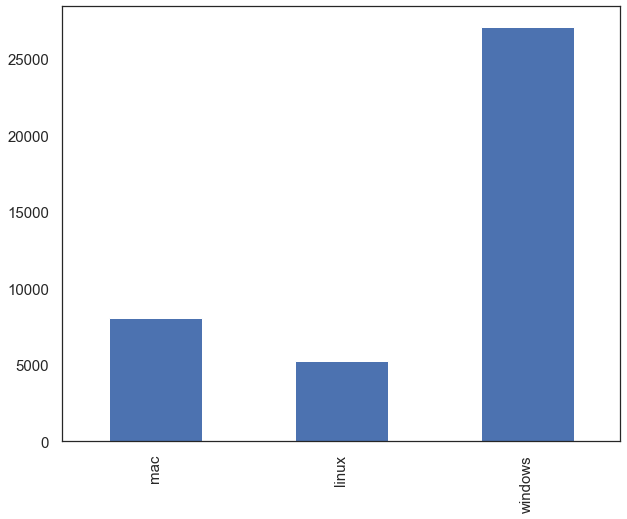

In [27]:
ax = platcolval.sum().plot.bar(figsize=(10,8), fontsize = 15)

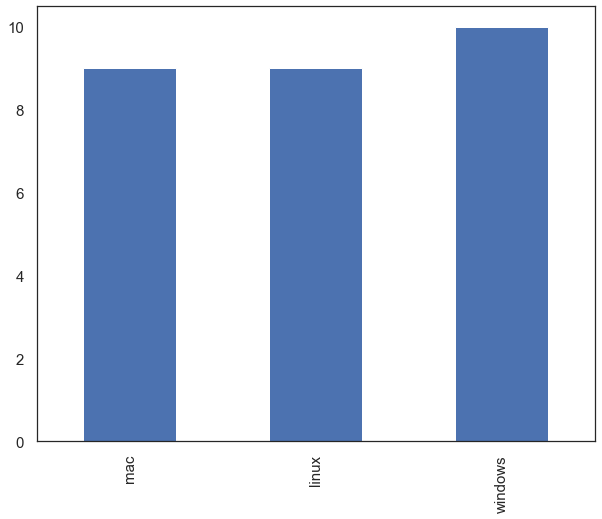

In [28]:
ax = df.sort_values(by='rating', ascending=False)[list(platformcols)].head(10).sum().plot.bar(figsize=(10,8), fontsize = 15)

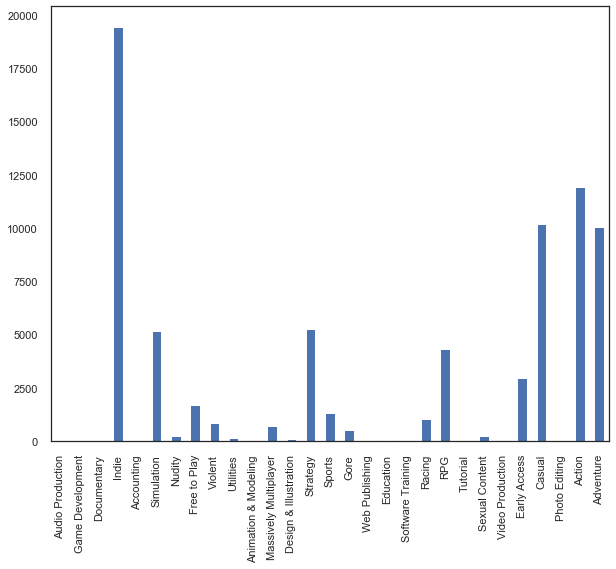

In [29]:
ax = gencolval.sum().plot.bar(figsize=(10,8))

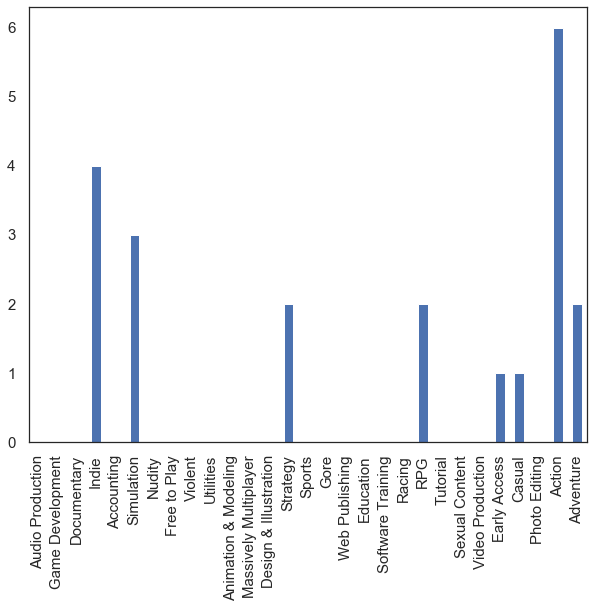

In [30]:
ax = df.sort_values(by='rating', ascending=False)[list(genrecols)].head(10).sum().plot.bar(figsize=(10,8), fontsize = 15)

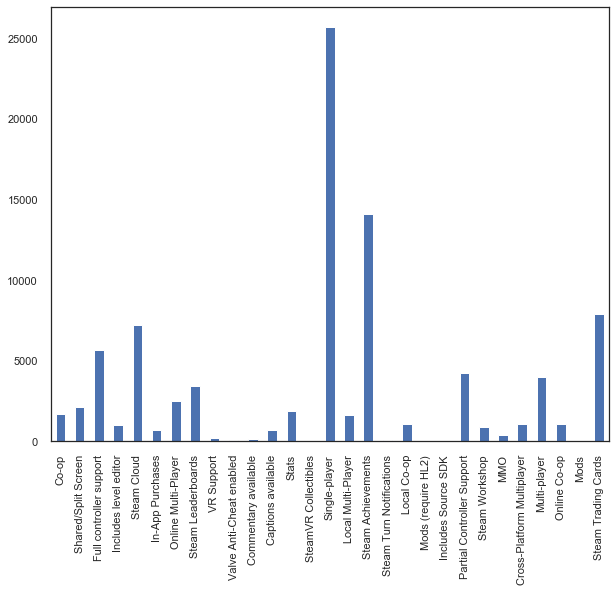

In [31]:
ax = catcolval.sum().plot.bar(figsize=(10,8))

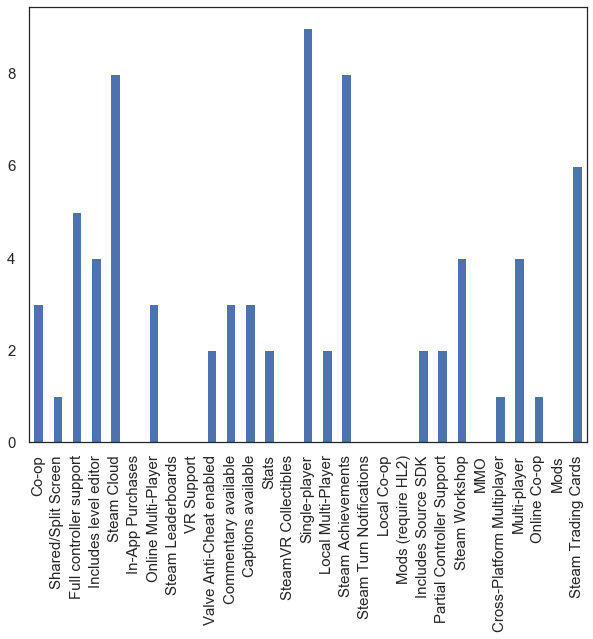

In [32]:
ax = df.sort_values(by='rating', ascending=False)[list(categorycols)].head(10).sum().plot.bar(figsize=(10,8), fontsize = 15)

# Hypothesis Testing

## Test 1:

Null Hypothesis: There is no statisically significant difference in average rating across platforms.

Alternative Hypothesis: There is a statisically significant difference in average rating across platforms.

In [33]:
#print(platcolval['linux'].value_counts())
#print(platcolval['mac'].value_counts())
#print(platcolval['windows'].value_counts())

linux = df.sort_values(by='linux', ascending=False).head(5235)
print(linux['rating'].mean())
mac = df.sort_values(by='mac', ascending=False).head(8066)
print(mac['rating'].mean())
windows = df.sort_values(by='windows', ascending=False).head(27070)
print(windows['rating'].mean())

0.6952754722263711
0.6844579028705016
0.6433503282605261


In [34]:
stats.f_oneway(linux['rating'], mac['rating'], windows['rating'])

F_onewayResult(statistic=466.51266101738497, pvalue=5.035619982069032e-201)

## Test 2:

Null Hypothesis: There is no statisically significant difference in average rating across Top 10 genres.

Alternative Hypothesis: There is a statisically significant difference in average rating across Top 10 genres.

In [35]:
#print(gencolval['Action'].value_counts())
#print(gencolval['Casual'].value_counts())
#print(gencolval['RPG'].value_counts())
#print(gencolval['Early Access'].value_counts())
#print(gencolval['Indie'].value_counts())
#print(gencolval['Simulation'].value_counts())
#print(gencolval['Strategy'].value_counts())
#print(gencolval['Adventure'].value_counts())

action = df.sort_values(by='Action', ascending=False).head(11903)
print(action['rating'].mean())
casual = df.sort_values(by='Casual', ascending=False).head(10210)
print(casual['rating'].mean())
rpg = df.sort_values(by='RPG', ascending=False).head(4311)
print(rpg['rating'].mean())
earlyacc = df.sort_values(by='Early Access', ascending=False).head(2954)
print(earlyacc['rating'].mean())
indie = df.sort_values(by='Indie', ascending=False).head(7654)
print(indie['rating'].mean())
simulation = df.sort_values(by='Simulation', ascending=False).head(5194)
print(simulation['rating'].mean())
strategy = df.sort_values(by='Strategy', ascending=False).head(5247)
print(strategy['rating'].mean())
adventure = df.sort_values(by='Adventure', ascending=False).head(10032)
print(adventure['rating'].mean())

0.6413595843095746
0.629594291756776
0.6556495792793557
0.6240390648745799
0.6346286555567465
0.6148819361200676
0.6340244396607405
0.6459509381305035


In [36]:
stats.f_oneway(action['rating'], casual['rating'], rpg['rating'], earlyacc['rating'], indie['rating'], simulation['rating'], strategy['rating'], adventure['rating'])

F_onewayResult(statistic=43.89373482527991, pvalue=2.5338004440679598e-62)

## Test 3:

Null Hypothesis: There is no statisically significant difference in average rating across Top 10 categories.

Alternative Hypothesis: There is a statisically significant difference in average rating between across Top 10 categories.

In [37]:
#print(catcolval['Stats'].value_counts())
#print(catcolval['Includes Source SDK'].value_counts())
#print(catcolval['Multi-player'].value_counts())
#print(catcolval['Steam Achievements'].value_counts())
#print(catcolval['Shared/Split Screen'].value_counts())
#print(catcolval['Single-player'].value_counts())
#print(catcolval['Co-op'].value_counts())
#print(catcolval['Local Multi-Player'].value_counts())
#print(catcolval['Partial Controller Support'].value_counts())
#print(catcolval['Online Co-op'].value_counts())
#print(catcolval['Full controller support'].value_counts())
#print(catcolval['Captions available'].value_counts())
#print(catcolval['Valve Anti-Cheat enabled'].value_counts())
#print(catcolval['Steam Cloud'].value_counts())
#print(catcolval['Steam Workshop'].value_counts())
#print(catcolval['Cross-Platform Multiplayer'].value_counts())
#print(catcolval['Online Multi-Player'].value_counts())
#print(catcolval['Commentary available'].value_counts())
#print(catcolval['Steam Trading Cards'].value_counts())
#print(catcolval['Includes level editor'].value_counts())

sstats = df.sort_values(by='Stats', ascending=False).head(1878)
print(sstats['rating'].mean())
sdk = df.sort_values(by='Includes Source SDK', ascending=False).head(35)
print(sdk['rating'].mean())
mp = df.sort_values(by='Multi-player', ascending=False).head(3974)
print(mp['rating'].mean())
steamach = df.sort_values(by='Steam Achievements', ascending=False).head(14130)
print(steamach['rating'].mean())
shared = df.sort_values(by='Shared/Split Screen', ascending=False).head(2152)
print(shared['rating'].mean())
sp = df.sort_values(by='Single-player', ascending=False).head(1397)
print(sp['rating'].mean())
coop = df.sort_values(by='Co-op', ascending=False).head(1721)
print(coop['rating'].mean())
localmp = df.sort_values(by='Local Multi-Player', ascending=False).head(1615)
print(localmp['rating'].mean())
pcs = df.sort_values(by='Partial Controller Support', ascending=False).head(4234)
print(pcs['rating'].mean())
oncoop = df.sort_values(by='Online Co-op', ascending=False).head(1071)
print(oncoop['rating'].mean())
fcs = df.sort_values(by='Full controller support', ascending=False).head(5695)
print(fcs['rating'].mean())
caption = df.sort_values(by='Captions available', ascending=False).head(721)
print(caption['rating'].mean())
nocheat = df.sort_values(by='Valve Anti-Cheat enabled', ascending=False).head(94)
print(nocheat['rating'].mean())
cloud = df.sort_values(by='Steam Cloud', ascending=False).head(7219)
print(cloud['rating'].mean())
workshop = df.sort_values(by='Steam Workshop', ascending=False).head(897)
print(workshop['rating'].mean())
crossplat = df.sort_values(by='Cross-Platform Multiplayer', ascending=False).head(1081)
print(crossplat['rating'].mean())
onmp = df.sort_values(by='Online Multi-Player', ascending=False).head(2487)
print(onmp['rating'].mean())
comment = df.sort_values(by='Commentary available', ascending=False).head(144)
print(comment['rating'].mean())
tradecard = df.sort_values(by='Steam Trading Cards', ascending=False).head(7198)
print(tradecard['rating'].mean())
leveledit = df.sort_values(by='Includes level editor', ascending=False).head(1036)
print(leveledit['rating'].mean())

0.6756181728231616
0.7474592452882481
0.6529350906747
0.674196390159534
0.6764254155407398
0.6282228343266751
0.6709950811131584
0.6623000893386507
0.654180724882006
0.660014770898666
0.6936815255586599
0.6916981187627418
0.7730539799750586
0.7061923070641204
0.7265804695039914
0.6651522981606658
0.6454291336203531
0.6871025895074994
0.6874434050479382
0.7027647750320752


In [38]:
stats.f_oneway(sstats['rating'], sdk['rating'], mp['rating'], steamach['rating'], shared['rating'], sp['rating'], coop['rating'], localmp['rating'], pcs['rating'], oncoop['rating'], fcs['rating'], caption['rating'], nocheat['rating'], cloud['rating'], workshop['rating'], crossplat['rating'], onmp['rating'], comment['rating'], tradecard['rating'], leveledit['rating'])

F_onewayResult(statistic=68.94678706900405, pvalue=2.820653197972917e-263)

# OLS Modeling

1st Model: Base dataset itself is used, with features that are compatible with OLS modeling.

In [39]:
originaldf = pd.read_csv('steam.csv')
originaldf['totalreview'] = originaldf['positive_ratings'] + originaldf['negative_ratings']
originaldf['reviewscore'] = originaldf['positive_ratings'] / originaldf['totalreview']
originaldf['rating'] = originaldf['reviewscore'] - (originaldf['reviewscore'] - 0.5) * (2 ** (-np.log10(originaldf['totalreview'] + 1)))
originaldf.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,totalreview,reviewscore,rating
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,127873,0.973888,0.960136
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,3951,0.839787,0.811703
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,3814,0.895648,0.862598


In [40]:
original_model = ols(formula='rating~english+required_age+achievements+average_playtime+median_playtime+price',data=originaldf).fit()
original_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     123.0
Date:                Thu, 30 Jul 2020   Prob (F-statistic):          4.44e-154
Time:                        23:46:57   Log-Likelihood:                 14594.
No. Observations:               27075   AIC:                        -2.917e+04
Df Residuals:                   27068   BIC:                        -2.912e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6421      0.006    102.329      0.000       0.630       0.654
english             -0.0155      0.006     -2.455      0.014      -0.028      -0.003
required_age         0.0021      0.000      5.929      0.000       0.001       0.003
achievements     -7.611e-06   2.43e-06     -3.128      0.002   -1.24e-05   -2.84e-06
average_playtime  9.308e-06   1.17e-06      7.986      0.000    7.02e-06    1.16e-05
median_playtime  -4.632e-06   9.04e-07     -5.125      0.000    -6.4e-06   -2.86e-06
price                0.0025      0.000     22.851      0.000       0.002       0.003
==============================================================================
Omnibus:                      840.066   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              916.875
Skew:                          -0.448   Prob(JB):                    8.00e-200
Kurtosis:                       2.897   Cond. No.                     3.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 2nd OLS model

2nd Model is now used with all cleaned dataset and ALL engineered features added.

In [41]:
finaldf = df.drop(columns=['name','developer','publisher', 'positive_ratings', 'negative_ratings', 'reviewscore', 'containachieve', 'Cost', 'Mods (require HL2)'])
finaldf

,achievements,average_playtime,median_playtime,price,release_year,days_from_launch,totalreview,rating,mac,linux,windows,Audio Production,Game Development,Documentary,Indie,Accounting,Simulation,Nudity,Free to Play,Violent,Utilities,Animation & Modeling,Massively Multiplayer,Design & Illustration,Strategy,Sports,Gore,Web Publishing,Education,Software Training,Racing,RPG,Tutorial,Sexual Content,Video Production,Early Access,Casual,Photo Editing,Action,Adventure,Co-op,Shared/Split Screen,Full controller support,Includes level editor,Steam Cloud,In-App Purchases,Online Multi-Player,Steam Leaderboards,VR Support,Valve Anti-Cheat enabled,Commentary available,Captions available,Stats,SteamVR Collectibles,Single-player,Local Multi-Player,Steam Achievements,Steam Turn Notifications,Local Co-op,Includes Source SDK,Partial Controller Support,Steam Workshop,MMO,Cross-Platform Multiplayer,Multi-player,Online Co-op,Mods,Steam Trading Cards,platnum,genrenum,catenum
0,0,17612,317,7.19,2000,6782,127873,0.960136,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,3,1,4
1,0,277,62,3.99,1999,7362,3951,0.811703,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,3,1,4
2,0,187,34,3.99,2003,5871,3814,0.862598,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,2
3,0,258,184,3.99,2001,6570,1540,0.790779,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,3,1,4
4,0,624,415,3.99,1999,7148,5538,0.914546,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,7,0,0,2.09,2019,34,3,0.670594,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,3,2
27071,0,0,0,1.69,2019,35,9,0.694444,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1
27072,24,0,0,3.99,2019,34,1,0.405836,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,3,7
27073,0,0,0,5.19,2019,41,2,0.640795,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,2


In [42]:
finaldf.columns = finaldf.columns.str.strip().str.replace('\s+', '_')
finaldf.columns = finaldf.columns.str.strip().str.replace('-', '')
finaldf.columns = finaldf.columns.str.strip().str.replace('&', 'and')
finaldf.columns = finaldf.columns.str.strip().str.replace('/', 'and')
featurelist = list(finaldf.columns)
featurelist.remove('rating')

In [43]:
game_model = ols(formula='rating~'+'+'.join(featurelist), data=finaldf).fit()
game_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     87.35
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:46:59   Log-Likelihood:                 16874.
No. Observations:               27055   AIC:                        -3.361e+04
Df Residuals:                   26987   BIC:                        -3.305e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.7832      5.537     -0.683      0.494     -14.636       7.069
achievements               -4.744e-06   2.28e-06     -2.084      0.037   -9.21e-06   -2.82e-07
average_playtime            4.928e-06   1.14e-06      4.330      0.000     2.7e-06    7.16e-06
median_playtime            -2.395e-06   8.69e-07     -2.755      0.006    -4.1e-06   -6.91e-07
price                          0.0029      0.000     20.351      0.000       0.003       0.003
release_year                   0.0021      0.003      0.784      0.433      -0.003       0.008
days_from_launch             2.69e-05   7.62e-06      3.530      0.000     1.2e-05    4.18e-05
totalreview                 1.501e-07   3.81e-08      3.939      0.000    7.54e-08    2.25e-07
mac                            0.0163      0.015      1.110      0.267      -0.012       0.045
linux                          0.0030      0.015      0.203      0.839      -0.026       0.032
windows                       -0.0104      0.044     -0.239      0.811      -0.096       0.075
Audio_Production              -0.0102      0.026     -0.388      0.698      -0.062       0.041
Game_Development              -0.0043      0.040     -0.106      0.915      -0.083       0.075
Documentary                   -0.0665      0.071     -0.936      0.349      -0.206       0.073
Indie                          0.0204      0.005      3.814      0.000       0.010       0.031
Accounting                    -0.0265      0.069     -0.386      0.699      -0.161       0.108
Simulation                    -0.0134      0.005     -2.474      0.013      -0.024      -0.003
Nudity                         0.0221      0.011      1.980      0.048       0.000       0.044
Free_to_Play                   0.0793      0.006     12.826      0.000       0.067       0.091
Violent                       -0.0222      0.008     -2.812      0.005      -0.038      -0.007
Utilities                      0.0013      0.015      0.091      0.927      -0.027       0.030
Animation_and_Modeling         0.0131      0.023      0.578      0.563      -0.031       0.057
Massively_Multiplayer         -0.0184      0.009     -2.123      0.034      -0.035      -0.001
Design_and_Illustration        0.0162      0.023      0.703      0.482      -0.029       0.061
Strategy                      -0.0070      0.005     -1.299      0.194      -0.018       0.004
Sports                        -0.0067      0.006     -1.069      0.285      -0.019       0.006
Gore                          -0.0012      0.009     -0.139      0.889      -0.019       0.016
Web_Publishing                 0.0615      0.032      1.926      0.054      -0.001       0.124
Education                      0.0109      0.026      0.426      0.670      -0.039       0.061
Software_Training             -0.0081      

In [44]:
finaldfcorr = finaldf.corr() 
finaldfcorr

,achievements,average_playtime,median_playtime,price,release_year,days_from_launch,totalreview,rating,mac,linux,windows,Audio_Production,Game_Development,Documentary,Indie,Accounting,Simulation,Nudity,Free_to_Play,Violent,Utilities,Animation_and_Modeling,Massively_Multiplayer,Design_and_Illustration,Strategy,Sports,Gore,Web_Publishing,Education,Software_Training,Racing,RPG,Tutorial,Sexual_Content,Video_Production,Early_Access,Casual,Photo_Editing,Action,Adventure,Coop,SharedandSplit_Screen,Full_controller_support,Includes_level_editor,Steam_Cloud,InApp_Purchases,Online_MultiPlayer,Steam_Leaderboards,VR_Support,Valve_AntiCheat_enabled,Commentary_available,Captions_available,Stats,SteamVR_Collectibles,Singleplayer,Local_MultiPlayer,Steam_Achievements,Steam_Turn_Notifications,Local_Coop,Includes_Source_SDK,Partial_Controller_Support,Steam_Workshop,MMO,CrossPlatform_Multiplayer,Multiplayer,Online_Coop,Mods,Steam_Trading_Cards,platnum,genrenum,catenum
achievements,1.000000,0.014175,0.009957,-0.007710,0.034243,-0.033090,0.005813,-0.019346,-0.023553,-0.009535,0.001220,-0.003987,-0.003132,-0.000763,0.003169,-0.001896,0.034984,-0.006013,-0.016047,0.003008,-0.008898,-0.006617,-0.010043,-0.006906,0.038548,-0.010995,0.008167,-0.003923,-0.005419,-0.004257,-0.012395,0.003984,-0.000763,-0.000043,-0.004558,-0.030824,0.076451,-0.002647,0.016220,-0.029684,-0.005392,-0.015204,-0.024427,-0.004319,-0.003548,-0.005017,-0.019289,0.005792,-0.008360,0.003831,0.006712,-0.007753,0.014561,-0.002811,0.017678,-0.017380,0.110645,0.000225,-0.012118,-0.000401,-0.025051,0.000406,-0.006010,-0.002229,-0.021968,-0.004764,0.003199,-0.012211,-0.018882,0.031121,0.003737
average_playtime,0.014175,1.000000,0.914900,0.059982,-0.052997,0.053083,0.164463,0.056921,0.027909,0.031488,0.001114,-0.002645,-0.000464,-0.000498,-0.032232,-0.001221,0.001183,-0.002717,0.057397,-0.009975,-0.001501,-0.001826,0.052192,-0.001168,0.011627,-0.004252,-0.007954,-0.000239,-0.002541,-0.002596,-0.000823,0.030293,-0.000498,-0.003421,-0.002520,-0.013122,-0.027567,0.003225,-0.002806,0.000778,0.044763,-0.005674,-0.001153,0.022921,0.015234,0.037693,0.025424,0.003494,0.008045,0.062833,0.011388,0.022218,0.012355,0.010677,-0.039834,-0.003823,0.008887,-0.001631,-0.006631,0.014696,0.008829,0.048749,0.060464,0.043157,0.050282,0.027121,0.001800,0.044287,0.032787,0.000284,0.050046
median_playtime,0.009957,0.914900,1.000000,0.044591,-0.034508,0.034467,0.039437,0.038002,0.019626,0.021210,0.000843,-0.002001,-0.000320,-0.000377,-0.016234,-0.000924,-0.000974,-0.002162,0.042509,-0.007377,0.000037,-0.001599,0.025372,-0.001078,0.012702,-0.004083,-0.005856,-0.000105,-0.001836,-0.001875,-0.001126,0.026861,-0.000377,-0.002287,-0.001859,-0.009670,-0.016380,0.002540,-0.010399,0.003395,0.023927,-0.003633,-0.002131,0.010535,0.013896,0.013538,0.012353,0.003254,0.001156,0.013024,0.005816,0.021788,0.005549,-0.000940,-0.027536,-0.004757,0.003200,-0.000641,-0.006000,0.003598,0.001751,0.026208,0.031326,0.038327,0.032173,0.013669,-0.000017,0.029518,0.022579,0.002304,0.028004
price,-0.007710,0.059982,0.044591,1.000000,-0.071628,0.070422,0.049460,0.179555,0.022789,0.024462,0.003333,0.010554,0.031390,-0.001857,-0.233476,-0.006987,0.078490,0.019961,-0.233105,0.002060,0.030581,0.048447,-0.047245,0.072520,0.068386,0.065929,-0.006143,0.060415,0.040704,0.037704,0.030425,0.064311,-0.001857,0.012724,0.008282,0.054243,-0.224499,0.027929,0.016324,0.011007,0.105717,0.070633,0.156264,0.065032,0.223959,-0.069232,0.096262,0.041939,0.036754,0.055530,-0.006777,0.022622,0.015357,0.060011,0.036382,0.065212,0.118190,0.012228,0.055896,-0.012597,0.035759,0.125710,-0.040591,0.011928,0.144633,0.087875,-0.007861,0.142864,0.026171,-0.096591,0.235474
release_year,0.034243,-0.052997,-0.034508,-0.071628,1.000000,-0.991018,-0.061168,-0.142056,-0.088161,-0.082492,0.001878,0.003955,0.005833,0.004232,0.235968,0.005765,0.063923,0.018317,0.056567,0.054826,0.005910,0.000841,0.031320,-0.001311,-0.043083,0.040325,0.044767,-0.006897,-0.004503,-0.008831,-0.004493,0.0

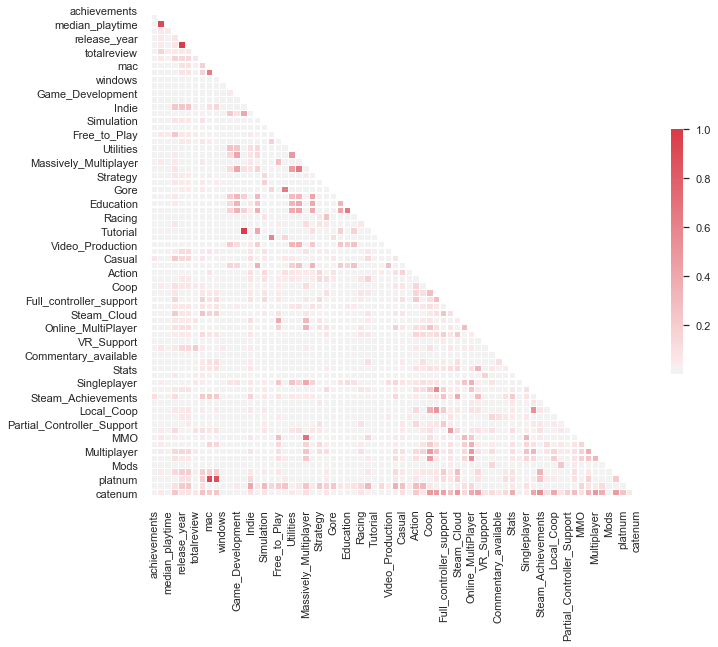

In [45]:
sns.set(style="white")  #using a heat map to display the visuals for the correlations in the dataset
# Compute the correlation matrix
corr = np.abs(finaldf.corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

# 3rd OLS Model

Features that had P>|t| values greater than 0.05 are removed, as they are considered to have no significant correlation with the target variable.

In [50]:
featurelist = [e for e in featurelist if e not in ('Adventure', 'MMO', 'RPG', 'Tutorial', 'Web_Publishing', 'Software_Training', 'Accounting', 'Game_Development', 'Utilities', 'Video_Production', 'Photo_Editing', 'Education', 'Gore', 'Documentary', 'Design_and_Illustration', 'Nudity', 'Animation_and_Modeling', 'Audio_Production', 'VR_Support', 'Includes_Source_SDK', 'SharedandSplit_Screen', 'Steam_Turn_Notifications', 'Coop', 'Local_MultiPlayer', 'Online_Coop', 'Mods', 'Captions_available', 'Valve_AntiCheat_enabled', 'CrossPlatform_Multiplayer', 'Commentary_available', 'release_year', 'platnum','genrenum','catenum','windows')]

In [62]:
finalgame_model = ols(formula='rating~'+'+'.join(featurelist), data=finaldf).fit()
finalgame_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     166.3
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        23:59:11   Log-Likelihood:                 16858.
No. Observations:               27055   AIC:                        -3.364e+04
Df Residuals:                   27019   BIC:                        -3.335e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5543      0.005    116.397      0.000       0.545       0.564
achievements               -4.637e-06   2.27e-06     -2.038      0.042    -9.1e-06   -1.78e-07
average_playtime            5.001e-06   1.13e-06      4.406      0.000    2.78e-06    7.23e-06
median_playtime            -2.456e-06   8.67e-07     -2.832      0.005   -4.16e-06   -7.56e-07
price                          0.0029      0.000     20.659      0.000       0.003       0.003
days_from_launch            2.127e-05   1.15e-06     18.545      0.000     1.9e-05    2.35e-05
totalreview                  1.65e-07   3.75e-08      4.396      0.000    9.14e-08    2.39e-07
mac                            0.0249      0.002     11.063      0.000       0.020       0.029
linux                          0.0119      0.003      4.553      0.000       0.007       0.017
Indie                          0.0106      0.002      5.352      0.000       0.007       0.014
Simulation                    -0.0232      0.002    -10.892      0.000      -0.027      -0.019
Free_to_Play                   0.0690      0.004     18.376      0.000       0.062       0.076
Violent                       -0.0371      0.005     -7.969      0.000      -0.046      -0.028
Massively_Multiplayer         -0.0365      0.006     -6.370      0.000      -0.048      -0.025
Strategy                      -0.0165      0.002     -7.798      0.000      -0.021      -0.012
Sports                        -0.0161      0.004     -4.118      0.000      -0.024      -0.008
Racing                        -0.0278      0.004     -6.365      0.000      -0.036      -0.019
Sexual_Content                 0.0327      0.008      3.855      0.000       0.016       0.049
Early_Access                   0.0062      0.003      2.303      0.021       0.001       0.012
Casual                        -0.0054      0.002     -3.125      0.002      -0.009      -0.002
Action                        -0.0168      0.002     -9.450      0.000      -0.020      -0.013
Full_controller_support        0.0282      0.002     12.180      0.000       0.024       0.033
Includes_level_editor          0.0147      0.005      3.104      0.002       0.005       0.024
Steam_Cloud                    0.0406      0.002     19.713      0.000       0.037       0.045
InApp_Purchases               -0.0369      0.006     -6.322      0.000      -0.048      -0.025
Online_MultiPlayer             0.0197      0.004      5.580      0.000       0.013       0.027
Steam_Leaderboards             0.0160      0.003      6.019      0.000       0.011       0.021
Stats                         -0.0082      0.003     -2.449      0.014      -0.015      -0.002
SteamVR_Collectibles           0.1374      0.021      6.654      0.000       0.097       0.178
Singleplayer                   0.0129      

In [52]:
finaldffeature = finaldf[featurelist]
finaldffeature

,achievements,average_playtime,median_playtime,price,days_from_launch,totalreview,mac,linux,Indie,Simulation,Free_to_Play,Violent,Massively_Multiplayer,Strategy,Sports,Racing,Sexual_Content,Early_Access,Casual,Action,Full_controller_support,Includes_level_editor,Steam_Cloud,InApp_Purchases,Online_MultiPlayer,Steam_Leaderboards,Stats,SteamVR_Collectibles,Singleplayer,Steam_Achievements,Local_Coop,Partial_Controller_Support,Steam_Workshop,Multiplayer,Steam_Trading_Cards
0,0,17612,317,7.19,6782,127873,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,277,62,3.99,7362,3951,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,187,34,3.99,5871,3814,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,258,184,3.99,6570,1540,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0,624,415,3.99,7148,5538,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,7,0,0,2.09,34,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
27071,0,0,0,1.69,35,9,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
27072,24,0,0,3.99,34,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0
27073,0,0,0,5.19,41,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [53]:
corr = finaldffeature.corr()
corr.style.background_gradient(cmap="coolwarm").set_precision(2)

# Train Test Split

In [54]:
finaldffeature['price'] = finaldffeature['price'].fillna(0).astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
from sklearn.model_selection import train_test_split
target = finaldf['rating']
X_train, X_test, y_train, y_test = train_test_split(finaldffeature, target, random_state=22, test_size=0.2)

In [67]:
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ", y_test.shape)

Training set - Features:  (21660, 35) Target:  (21660,)
Training set - Features:  (5415, 35) Target:  (5415,)


In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scale = pd.DataFrame(data=scaler.transform(X_train), columns=finaldffeature.columns)

X_test_scale = pd.DataFrame(data=scaler.transform(X_test), columns=finaldffeature.columns)

In [80]:
# fit a model
from sklearn import linear_model
from sklearn import metrics

#instantiate a linear regression object
lm = linear_model.LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)
print("R^2 Score:", metrics.r2_score(y_train, (y_train_pred)))

Training Root Mean Squared Error: 0.12976645510617033
R^2 Score: 0.17650272788150645


In [81]:
#use fitted model to predict on the test examples
y_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 0.1295355089357822
Training:  0 vs. Testing:  0


In [82]:
#calculate # of standard deviations the average error is away from the true value
sde = test_rmse / y_test.std()
sde

0.903916672453807

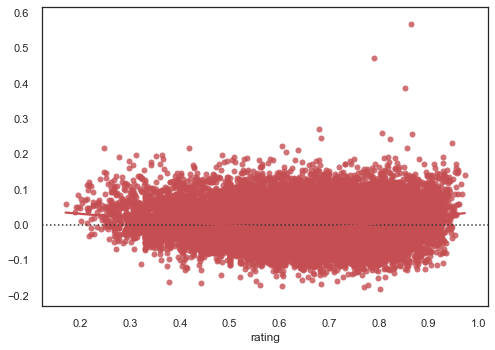

In [84]:
sns.residplot(y_train, y_train_pred,lowess=True, color="r")

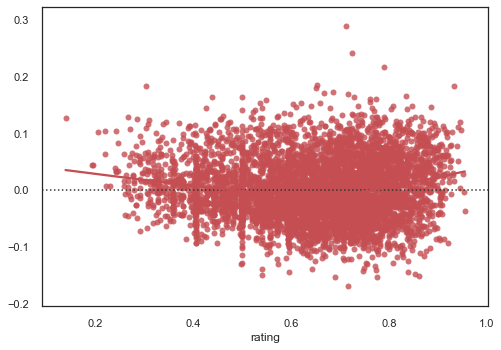

In [85]:
sns.residplot(y_test, y_pred,lowess=True, color="r")